# Initialize notebook

In [1]:
%pylab inline
import aquila_borg as borg
import aquila as aq
import numpy as np

Populating the interactive namespace from numpy and matplotlib
[INFO   ] libLSS version v2.0.0alpha-194-g4fdb32a5 built-in modules ares_fg;borg;dm_sheet;hades;hmclet;python
[INFO S ] Registered forward models:
[INFO S ]   - 2LPT_CIC
[INFO S ]   - 2LPT_CIC_OPENMP
[INFO S ]   - 2LPT_DOUBLE
[INFO S ]   - 2LPT_NGP
[INFO S ]   - Downgrade
[INFO S ]   - EnforceMass
[INFO S ]   - HADES_LOG
[INFO S ]   - HADES_PT
[INFO S ]   - Haar
[INFO S ]   - LPT_CIC
[INFO S ]   - LPT_CIC_OPENMP
[INFO S ]   - LPT_DOUBLE
[INFO S ]   - LPT_NGP
[INFO S ]   - PATCH_MODEL
[INFO S ]   - PM_CIC
[INFO S ]   - PM_CIC_OPENMP
[INFO S ]   - PRIMORDIAL
[INFO S ]   - PRIMORDIAL_FNL
[INFO S ]   - QLPT
[INFO S ]   - QLPT_RSD
[INFO S ]   - Softplus
[INFO S ]   - TRANSFER_EHU
[INFO S ]   - Transfer
[INFO S ]   - Upgrade
[INFO S ]   - bias::BrokenPowerLaw
[INFO S ]   - bias::DoubleBrokenPowerLaw
[INFO S ]   - bias::EFT
[INFO S ]   - bias::EFT_Thresh
[INFO S ]   - bias::Linear
[INFO S ]   - bias::ManyPower_1^1
[INFO S ]   - bi

# Chose a box and cosmological parameters

In [3]:
bb = borg.forward.BoxModel()
bb.N=64,64,64
cpar = borg.cosmo.CosmologicalParameters()
x = np.fft.rfftn(np.random.randn(*bb.N)/bb.Ntot**0.5)
delta_set={}

## Run a 2LPT simulation

[STD    ] |     ___________                              
[STD    ] |    /-/_"/-/_/-/|     __________________________ 
[STD    ] |   /"-/-_"/-_//||                BORG3 model
[STD    ] |  /__________/|/|     (c) Jens Jasche 2012 - 2019
[STD    ] |  |"|_'='-]:+|/||        Guilhem Lavaux 2014 - 2019
[STD    ] |  |-+-|.|_'-"||//     __________________________ 
[STD    ] |  |[".[:!+-'=|//     
[STD    ] |  |='!+|-:]|-|/       
[STD    ] |   ----------         
[STD    ] | 
[STD    ] | Please acknowledge the following papers:
[STD    ] |   - Jasche & Lavaux (A&A, 2019, arXiv 1806.11117)
[STD    ] |   - Jasche & Wandelt (MNRAS, 2012, arXiv 1203.3639)
[STD    ] |   - Jasche & Kitaura (MNRAS, 2010, arXiv 0911.2496)
[STD    ] |   - And relevant papers depending on the used sub-module/contribution
[STD    ] | 

[STD    ] | This is BORG version 7647fd4efc0604e6073b38472c31486fd514667a


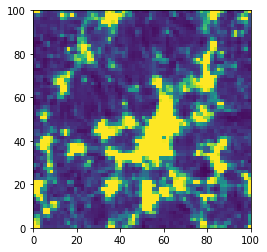

In [6]:
chain = borg.forward.ChainForwardModel(bb)
chain.addModel(borg.forward.models.HermiticEnforcer(bb))
chain.addModel(borg.forward.models.Primordial(bb, 1.0))
ehu = borg.forward.models.EisensteinHu(bb)
chain.addModel(ehu)
lpt = borg.forward.models.Borg2Lpt(bb, bb, ai=1.0, 
                            supersampling=2)
chain.addModel(lpt)
chain.setCosmoParams(cpar)

chain.forwardModel_v2(x)
delta_2lpt=np.empty(bb.N)
chain.getDensityFinal(delta_2lpt)

imshow(delta_2lpt[:,32,:],extent=(0,bb.L[0],0,bb.L[1]),vmin=-1,vmax=1)

## Run t-COLA simulation

In [7]:
def print_step(t,i):
    print(f" --- stepping t={t}, i={i}")

borg.console().setVerboseLevel(1)
for ff in [2,4]:
    for n in [5,10,20,40,80]:
        print(f"Running with {n} steps, ff={ff}...")
        chain = borg.forward.ChainForwardModel(bb)
        chain.addModel(borg.forward.models.HermiticEnforcer(bb))
        chain.addModel(borg.forward.models.Primordial(bb, 1.0))
        ehu = borg.forward.models.EisensteinHu(bb)
        chain.addModel(ehu)
        pm = borg.forward.models.BorgPM(bb, bb, ai=1.0, 
                                        nsteps=n, supersampling=2, force_factor=ff, z_start=50., tCOLA=True)
        pm.setStepNotifier(print_step)
        pm.setAdjointRequired(False)
        chain.addModel(pm)
        chain.setCosmoParams(cpar)

        chain.forwardModel_v2(x)
        delta_set[(ff,n)]=np.empty(bb.N)
        chain.getDensityFinal(delta_set[(ff,n)])
        delta_in=np.empty(bb.N)
        ehu.getDensityFinal(delta_in)

Running with 5 steps, ff=2...
 --- stepping t=0.14215686274509803, i=2097152
 --- stepping t=0.38725490196078427, i=2097152
 --- stepping t=0.6323529411764706, i=2097152
 --- stepping t=0.8774509803921569, i=2097152
Running with 10 steps, ff=2...
 --- stepping t=0.07407407407407407, i=2097152
 --- stepping t=0.1830065359477124, i=2097152
 --- stepping t=0.29193899782135074, i=2097152
 --- stepping t=0.40087145969498905, i=2097152
 --- stepping t=0.5098039215686274, i=2097152
 --- stepping t=0.6187363834422658, i=2097152
 --- stepping t=0.7276688453159041, i=2097152
 --- stepping t=0.8366013071895424, i=2097152
 --- stepping t=0.9455337690631808, i=2097152
Running with 20 steps, ff=2...
 --- stepping t=0.04540763673890609, i=2097152
 --- stepping t=0.09700722394220845, i=2097152
 --- stepping t=0.14860681114551083, i=2097152
 --- stepping t=0.2002063983488132, i=2097152
 --- stepping t=0.2518059855521156, i=2097152
 --- stepping t=0.30340557275541796, i=2097152
 --- stepping t=0.3550051

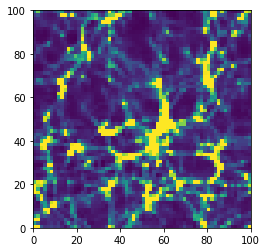

In [8]:
imshow(delta_set[(4,80)][:,32,:],extent=(0,bb.L[0],0,bb.L[1]),vmin=-1,vmax=1)

## Compute power spectra

/home/lavaux/.local/lib/python3.8/site-packages/PyAquila-1.0-py3.8.egg/aquila/clustering/power.py:53: RuntimeWarning: invalid value encountered in true_divide


(0.9, 1.2)

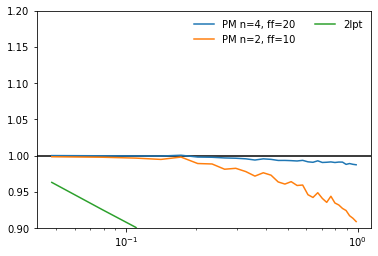

In [9]:
H_set={}

for k in delta_set:
    bc, H = aq.clustering.power.compute_power_spectrum(delta_set[k], bb.L[0],logk=False)
    #print(k)
    H_set[k] = H
bc, H_in = aq.clustering.power.compute_power_spectrum(delta_in, bb.L[0],logk=False)
_, H_2lpt = aq.clustering.power.compute_power_spectrum(delta_2lpt, bb.L[0],logk=False)

axhline(1.0,color='k')
for n,ff in [(4,20),(2,10)]:#H_set:
    semilogx(bc,H_set[(n,ff)]/H_set[(4,80)],label=f'PM n={n}, ff={ff}')
semilogx(bc,H_2lpt/H_set[(4,80)],label=f'2lpt')    
legend(frameon=False,ncol=2)
ylim(0.9,1.2)